In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Dataset preparation
def dataset_prep(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
def train(model, optimizer, train_loader):
    model.train()
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_losses = []
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = sum(batch_losses) / len(train_loader.dataset)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy


In [13]:
def test(model, test_loader):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    test_losses = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy

In [14]:
def interpolate_models(model1, model2, train_loader, test_loader):
    alpha_values = np.linspace(-2, 2, 10)
    train_losses, train_accs = [], []
    test_losses, test_accs = [], [] 
    for alpha in alpha_values:
        interpolated_model = Model().to(device)
        interpolated_params = {}

        for param_name, param_m1 in model1.named_parameters():
            param_m2 = model2.state_dict()[param_name]
            interpolated_params[param_name] = (1 - alpha) * param_m1 + alpha * param_m2

        interpolated_model.load_state_dict(interpolated_params)

        # Evaluate interpolated model
        train_loss, train_acc = evaluate(interpolated_model, train_loader)
        test_loss, test_acc = evaluate(interpolated_model, test_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    return alpha_values, train_losses, train_accs, test_losses, test_accs

In [15]:
def evaluate(model, loader):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_losses = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels)
            batch_losses.append(loss.item())
            
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = sum(batch_losses) / len(loader.dataset)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy

In [16]:
epochs = 24
train_loss_dict, train_acc_dict = {}, {}
test_loss_dict, test_acc_dict = {}, {}
model_state = {}

for batch_size in [64, 1024]:
    for lr in [1e-3, 1e-2]:
        train_loader, test_loader = dataset_prep(batch_size)
        model = Model().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            train_loss, train_acc = train(model, optimizer, train_loader)
            test_loss, test_acc = test(model, test_loader)
            print(f"Epoch {epoch+1}/{epochs}, Batch Size: {batch_size}, LR: {lr}, "
                  f"Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, "
                  f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        key = f"model_bs_{batch_size}_lr_{lr}"
        model_state[key] = model

train_loader, test_loader = dataset_prep(1024)
alpha_values, train_losses, train_accs, test_losses, test_accs = interpolate_models(
    model_state["model_bs_64_lr_0.001"], model_state["model_bs_1024_lr_0.001"], train_loader, test_loader)


100%|██████████| 938/938 [00:07<00:00, 132.98it/s]


Epoch 1/24, Batch Size: 64, LR: 0.001, Train Loss: 0.006020, Test Loss: 0.003595, Train Acc: 88.71%, Test Acc: 92.92%


100%|██████████| 938/938 [00:07<00:00, 133.10it/s]


Epoch 2/24, Batch Size: 64, LR: 0.001, Train Loss: 0.003027, Test Loss: 0.002642, Train Acc: 94.25%, Test Acc: 95.04%


100%|██████████| 938/938 [00:07<00:00, 132.92it/s]


Epoch 3/24, Batch Size: 64, LR: 0.001, Train Loss: 0.002441, Test Loss: 0.002387, Train Acc: 95.35%, Test Acc: 95.32%


100%|██████████| 938/938 [00:06<00:00, 134.80it/s]


Epoch 4/24, Batch Size: 64, LR: 0.001, Train Loss: 0.002099, Test Loss: 0.002146, Train Acc: 95.97%, Test Acc: 95.97%


100%|██████████| 938/938 [00:06<00:00, 134.39it/s]


Epoch 5/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001845, Test Loss: 0.002088, Train Acc: 96.41%, Test Acc: 96.02%


100%|██████████| 938/938 [00:06<00:00, 135.06it/s]


Epoch 6/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001645, Test Loss: 0.002045, Train Acc: 96.77%, Test Acc: 96.15%


100%|██████████| 938/938 [00:06<00:00, 134.34it/s]


Epoch 7/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001495, Test Loss: 0.001959, Train Acc: 97.10%, Test Acc: 96.07%


100%|██████████| 938/938 [00:06<00:00, 134.92it/s]


Epoch 8/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001381, Test Loss: 0.002019, Train Acc: 97.25%, Test Acc: 96.01%


100%|██████████| 938/938 [00:06<00:00, 134.21it/s]


Epoch 9/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001286, Test Loss: 0.001783, Train Acc: 97.41%, Test Acc: 96.64%


100%|██████████| 938/938 [00:06<00:00, 135.02it/s]


Epoch 10/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001196, Test Loss: 0.001975, Train Acc: 97.58%, Test Acc: 96.31%


100%|██████████| 938/938 [00:06<00:00, 134.49it/s]


Epoch 11/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001114, Test Loss: 0.001967, Train Acc: 97.81%, Test Acc: 96.38%


100%|██████████| 938/938 [00:06<00:00, 135.05it/s]


Epoch 12/24, Batch Size: 64, LR: 0.001, Train Loss: 0.001048, Test Loss: 0.002103, Train Acc: 97.84%, Test Acc: 96.24%


100%|██████████| 938/938 [00:06<00:00, 134.19it/s]


Epoch 13/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000997, Test Loss: 0.002111, Train Acc: 97.97%, Test Acc: 96.25%


100%|██████████| 938/938 [00:06<00:00, 134.83it/s]


Epoch 14/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000928, Test Loss: 0.001835, Train Acc: 98.10%, Test Acc: 96.66%


100%|██████████| 938/938 [00:06<00:00, 134.11it/s]


Epoch 15/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000869, Test Loss: 0.001893, Train Acc: 98.18%, Test Acc: 96.69%


100%|██████████| 938/938 [00:06<00:00, 134.85it/s]


Epoch 16/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000847, Test Loss: 0.001940, Train Acc: 98.21%, Test Acc: 96.58%


100%|██████████| 938/938 [00:06<00:00, 134.60it/s]


Epoch 17/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000816, Test Loss: 0.001857, Train Acc: 98.22%, Test Acc: 96.68%


100%|██████████| 938/938 [00:06<00:00, 134.58it/s]


Epoch 18/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000751, Test Loss: 0.001903, Train Acc: 98.42%, Test Acc: 96.58%


100%|██████████| 938/938 [00:06<00:00, 135.02it/s]


Epoch 19/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000735, Test Loss: 0.002136, Train Acc: 98.42%, Test Acc: 96.42%


100%|██████████| 938/938 [00:06<00:00, 134.85it/s]


Epoch 20/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000716, Test Loss: 0.002276, Train Acc: 98.48%, Test Acc: 96.18%


100%|██████████| 938/938 [00:06<00:00, 134.85it/s]


Epoch 21/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000658, Test Loss: 0.001978, Train Acc: 98.59%, Test Acc: 96.71%


100%|██████████| 938/938 [00:06<00:00, 134.45it/s]


Epoch 22/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000632, Test Loss: 0.002200, Train Acc: 98.63%, Test Acc: 96.51%


100%|██████████| 938/938 [00:06<00:00, 134.61it/s]


Epoch 23/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000617, Test Loss: 0.002135, Train Acc: 98.62%, Test Acc: 96.75%


100%|██████████| 938/938 [00:06<00:00, 134.47it/s]


Epoch 24/24, Batch Size: 64, LR: 0.001, Train Loss: 0.000588, Test Loss: 0.002267, Train Acc: 98.74%, Test Acc: 96.40%


100%|██████████| 938/938 [00:06<00:00, 134.33it/s]


Epoch 1/24, Batch Size: 64, LR: 0.01, Train Loss: 0.004971, Test Loss: 0.003226, Train Acc: 90.41%, Test Acc: 93.63%


100%|██████████| 938/938 [00:06<00:00, 134.30it/s]


Epoch 2/24, Batch Size: 64, LR: 0.01, Train Loss: 0.003154, Test Loss: 0.002927, Train Acc: 94.14%, Test Acc: 94.27%


100%|██████████| 938/938 [00:06<00:00, 134.45it/s]


Epoch 3/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002804, Test Loss: 0.002522, Train Acc: 94.81%, Test Acc: 95.42%


100%|██████████| 938/938 [00:06<00:00, 134.24it/s]


Epoch 4/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002640, Test Loss: 0.003209, Train Acc: 95.24%, Test Acc: 94.51%


100%|██████████| 938/938 [00:06<00:00, 134.81it/s]


Epoch 5/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002545, Test Loss: 0.002649, Train Acc: 95.44%, Test Acc: 95.46%


100%|██████████| 938/938 [00:06<00:00, 134.45it/s]


Epoch 6/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002468, Test Loss: 0.002762, Train Acc: 95.55%, Test Acc: 95.15%


100%|██████████| 938/938 [00:06<00:00, 134.69it/s]


Epoch 7/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002320, Test Loss: 0.002618, Train Acc: 95.93%, Test Acc: 95.52%


100%|██████████| 938/938 [00:06<00:00, 134.61it/s]


Epoch 8/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002355, Test Loss: 0.002856, Train Acc: 95.89%, Test Acc: 95.26%


100%|██████████| 938/938 [00:06<00:00, 134.94it/s]


Epoch 9/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002176, Test Loss: 0.002688, Train Acc: 96.16%, Test Acc: 95.61%


100%|██████████| 938/938 [00:06<00:00, 134.67it/s]


Epoch 10/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002193, Test Loss: 0.002692, Train Acc: 96.22%, Test Acc: 95.80%


100%|██████████| 938/938 [00:06<00:00, 134.79it/s]


Epoch 11/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002135, Test Loss: 0.002762, Train Acc: 96.29%, Test Acc: 95.73%


100%|██████████| 938/938 [00:06<00:00, 134.30it/s]


Epoch 12/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002066, Test Loss: 0.002995, Train Acc: 96.42%, Test Acc: 95.81%


100%|██████████| 938/938 [00:06<00:00, 134.87it/s]


Epoch 13/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002144, Test Loss: 0.002925, Train Acc: 96.29%, Test Acc: 95.70%


100%|██████████| 938/938 [00:06<00:00, 134.42it/s]


Epoch 14/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002061, Test Loss: 0.002717, Train Acc: 96.45%, Test Acc: 96.08%


100%|██████████| 938/938 [00:06<00:00, 134.73it/s]


Epoch 15/24, Batch Size: 64, LR: 0.01, Train Loss: 0.002009, Test Loss: 0.002920, Train Acc: 96.43%, Test Acc: 95.71%


100%|██████████| 938/938 [00:06<00:00, 134.51it/s]


Epoch 16/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001939, Test Loss: 0.003055, Train Acc: 96.55%, Test Acc: 95.43%


100%|██████████| 938/938 [00:06<00:00, 134.87it/s]


Epoch 17/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001999, Test Loss: 0.002967, Train Acc: 96.56%, Test Acc: 95.64%


100%|██████████| 938/938 [00:06<00:00, 134.95it/s]


Epoch 18/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001893, Test Loss: 0.003022, Train Acc: 96.69%, Test Acc: 95.87%


100%|██████████| 938/938 [00:06<00:00, 134.63it/s]


Epoch 19/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001912, Test Loss: 0.002853, Train Acc: 96.75%, Test Acc: 95.88%


100%|██████████| 938/938 [00:06<00:00, 134.72it/s]


Epoch 20/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001904, Test Loss: 0.002816, Train Acc: 96.72%, Test Acc: 95.85%


100%|██████████| 938/938 [00:06<00:00, 134.82it/s]


Epoch 21/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001844, Test Loss: 0.003075, Train Acc: 96.86%, Test Acc: 95.86%


100%|██████████| 938/938 [00:06<00:00, 134.79it/s]


Epoch 22/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001899, Test Loss: 0.002733, Train Acc: 96.77%, Test Acc: 96.09%


100%|██████████| 938/938 [00:06<00:00, 134.70it/s]


Epoch 23/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001870, Test Loss: 0.003278, Train Acc: 96.86%, Test Acc: 95.77%


100%|██████████| 938/938 [00:06<00:00, 134.54it/s]


Epoch 24/24, Batch Size: 64, LR: 0.01, Train Loss: 0.001825, Test Loss: 0.003496, Train Acc: 96.91%, Test Acc: 95.51%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 1/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.001350, Test Loss: 0.000670, Train Acc: 55.55%, Test Acc: 83.65%


100%|██████████| 59/59 [00:06<00:00,  9.77it/s]


Epoch 2/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000460, Test Loss: 0.000345, Train Acc: 87.36%, Test Acc: 90.29%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 3/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000317, Test Loss: 0.000286, Train Acc: 90.83%, Test Acc: 91.77%


100%|██████████| 59/59 [00:06<00:00,  9.77it/s]


Epoch 4/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000268, Test Loss: 0.000250, Train Acc: 92.12%, Test Acc: 92.62%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 5/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000240, Test Loss: 0.000231, Train Acc: 92.95%, Test Acc: 93.43%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 6/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000217, Test Loss: 0.000211, Train Acc: 93.70%, Test Acc: 93.90%


100%|██████████| 59/59 [00:06<00:00,  9.80it/s]


Epoch 7/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000199, Test Loss: 0.000197, Train Acc: 94.23%, Test Acc: 94.28%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 8/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000184, Test Loss: 0.000190, Train Acc: 94.65%, Test Acc: 94.41%


100%|██████████| 59/59 [00:06<00:00,  9.81it/s]


Epoch 9/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000172, Test Loss: 0.000183, Train Acc: 95.01%, Test Acc: 94.47%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 10/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000161, Test Loss: 0.000166, Train Acc: 95.35%, Test Acc: 95.12%


100%|██████████| 59/59 [00:06<00:00,  9.75it/s]


Epoch 11/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000150, Test Loss: 0.000159, Train Acc: 95.57%, Test Acc: 95.59%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 12/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000140, Test Loss: 0.000155, Train Acc: 95.87%, Test Acc: 95.44%


100%|██████████| 59/59 [00:06<00:00,  9.80it/s]


Epoch 13/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000133, Test Loss: 0.000144, Train Acc: 96.07%, Test Acc: 95.86%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 14/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000126, Test Loss: 0.000141, Train Acc: 96.22%, Test Acc: 96.02%


100%|██████████| 59/59 [00:06<00:00,  9.61it/s]


Epoch 15/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000120, Test Loss: 0.000138, Train Acc: 96.42%, Test Acc: 95.99%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 16/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000115, Test Loss: 0.000132, Train Acc: 96.59%, Test Acc: 96.27%


100%|██████████| 59/59 [00:06<00:00,  9.80it/s]


Epoch 17/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000111, Test Loss: 0.000132, Train Acc: 96.67%, Test Acc: 96.20%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 18/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000105, Test Loss: 0.000128, Train Acc: 96.92%, Test Acc: 96.26%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 19/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000101, Test Loss: 0.000127, Train Acc: 96.92%, Test Acc: 96.18%


100%|██████████| 59/59 [00:06<00:00,  9.63it/s]


Epoch 20/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000098, Test Loss: 0.000121, Train Acc: 97.06%, Test Acc: 96.42%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 21/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000094, Test Loss: 0.000119, Train Acc: 97.17%, Test Acc: 96.62%


100%|██████████| 59/59 [00:06<00:00,  9.80it/s]


Epoch 22/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000090, Test Loss: 0.000117, Train Acc: 97.31%, Test Acc: 96.57%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 23/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000087, Test Loss: 0.000116, Train Acc: 97.38%, Test Acc: 96.64%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 24/24, Batch Size: 1024, LR: 0.001, Train Loss: 0.000084, Test Loss: 0.000116, Train Acc: 97.48%, Test Acc: 96.69%


100%|██████████| 59/59 [00:06<00:00,  9.60it/s]


Epoch 1/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000514, Test Loss: 0.000241, Train Acc: 83.38%, Test Acc: 93.13%


100%|██████████| 59/59 [00:06<00:00,  9.75it/s]


Epoch 2/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000211, Test Loss: 0.000193, Train Acc: 93.58%, Test Acc: 94.08%


100%|██████████| 59/59 [00:06<00:00,  9.80it/s]


Epoch 3/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000168, Test Loss: 0.000176, Train Acc: 94.79%, Test Acc: 94.72%


100%|██████████| 59/59 [00:06<00:00,  9.75it/s]


Epoch 4/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000143, Test Loss: 0.000151, Train Acc: 95.71%, Test Acc: 95.44%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 5/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000130, Test Loss: 0.000150, Train Acc: 96.00%, Test Acc: 95.60%


100%|██████████| 59/59 [00:06<00:00,  9.57it/s]


Epoch 6/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000113, Test Loss: 0.000151, Train Acc: 96.63%, Test Acc: 95.40%


100%|██████████| 59/59 [00:06<00:00,  9.75it/s]


Epoch 7/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000107, Test Loss: 0.000145, Train Acc: 96.65%, Test Acc: 95.71%


100%|██████████| 59/59 [00:06<00:00,  9.75it/s]


Epoch 8/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000100, Test Loss: 0.000144, Train Acc: 96.87%, Test Acc: 95.73%


100%|██████████| 59/59 [00:06<00:00,  9.73it/s]


Epoch 9/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000101, Test Loss: 0.000125, Train Acc: 96.92%, Test Acc: 96.20%


100%|██████████| 59/59 [00:06<00:00,  9.77it/s]


Epoch 10/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000085, Test Loss: 0.000130, Train Acc: 97.32%, Test Acc: 96.08%


100%|██████████| 59/59 [00:06<00:00,  9.57it/s]


Epoch 11/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000081, Test Loss: 0.000126, Train Acc: 97.48%, Test Acc: 96.38%


100%|██████████| 59/59 [00:06<00:00,  9.77it/s]


Epoch 12/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000075, Test Loss: 0.000126, Train Acc: 97.63%, Test Acc: 96.41%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 13/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000071, Test Loss: 0.000133, Train Acc: 97.79%, Test Acc: 96.16%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 14/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000071, Test Loss: 0.000133, Train Acc: 97.74%, Test Acc: 96.43%


100%|██████████| 59/59 [00:06<00:00,  9.74it/s]


Epoch 15/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000070, Test Loss: 0.000139, Train Acc: 97.77%, Test Acc: 96.00%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 16/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000066, Test Loss: 0.000123, Train Acc: 97.84%, Test Acc: 96.70%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 17/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000058, Test Loss: 0.000132, Train Acc: 98.16%, Test Acc: 96.46%


100%|██████████| 59/59 [00:06<00:00,  9.79it/s]


Epoch 18/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000057, Test Loss: 0.000142, Train Acc: 98.14%, Test Acc: 96.37%


100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


Epoch 19/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000058, Test Loss: 0.000143, Train Acc: 98.14%, Test Acc: 96.29%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 20/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000058, Test Loss: 0.000151, Train Acc: 98.14%, Test Acc: 96.39%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 21/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000053, Test Loss: 0.000141, Train Acc: 98.28%, Test Acc: 96.54%


100%|██████████| 59/59 [00:06<00:00,  9.74it/s]


Epoch 22/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000050, Test Loss: 0.000162, Train Acc: 98.36%, Test Acc: 96.10%


100%|██████████| 59/59 [00:06<00:00,  9.77it/s]


Epoch 23/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000051, Test Loss: 0.000147, Train Acc: 98.23%, Test Acc: 96.61%


100%|██████████| 59/59 [00:06<00:00,  9.78it/s]


Epoch 24/24, Batch Size: 1024, LR: 0.01, Train Loss: 0.000053, Test Loss: 0.000147, Train Acc: 98.25%, Test Acc: 96.59%


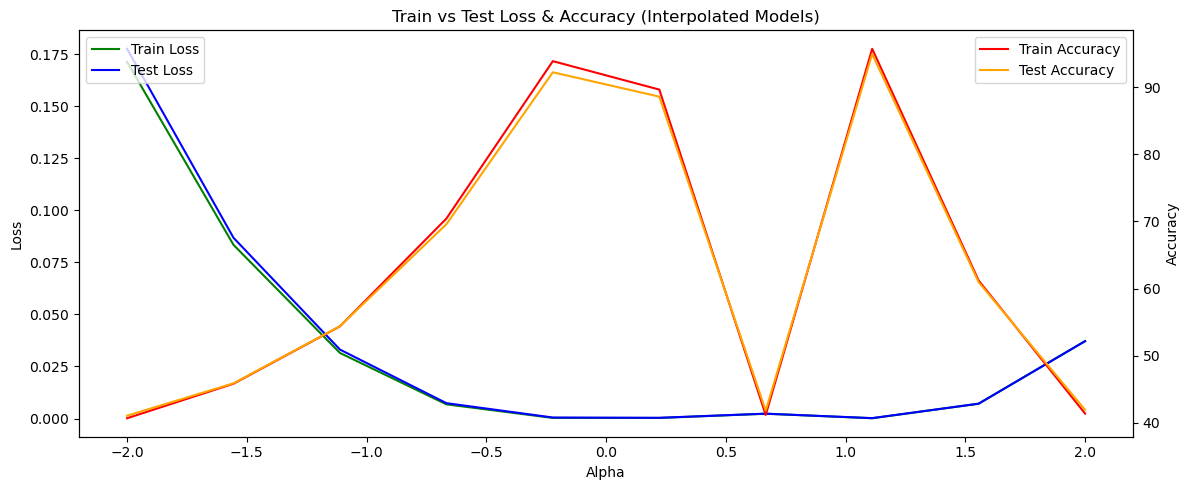

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(alpha_values, train_losses, color="green", label='Train Loss')
ax1.plot(alpha_values, test_losses, color="blue", label='Test Loss')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(alpha_values, train_accs, color="red", label='Train Accuracy')
ax2.plot(alpha_values, test_accs, color="orange", label='Test Accuracy')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Train vs Test Loss & Accuracy (Interpolated Models)')
plt.tight_layout()
plt.show()